In [80]:
# imports for the project
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import time
from google.colab import drive
from PIL import Image
drive.mount('/content/gdrive')
from shutil import copyfile


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# unzip test data
!unzip "/content/gdrive/MyDrive/CADDY_stereo_gesture_data/CADDY_gestures_complete_v2_release.zip"


Streaming output truncated to the last 5000 lines.
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00820_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00820_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00821_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00821_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00822_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00822_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00823_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00823_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00824_left.jpg  
  inflating: CADDY_gestures

In [81]:
#getting dataset params
csv_path = '/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv'

csv_data = pd.read_csv(csv_path)
csv_data = csv_data.drop(csv_data[csv_data['synthetic'] == 1].index)
csv_data = csv_data.drop(csv_data[pd.isna(csv_data['stereo left'])].index)
csv_data = csv_data.drop(csv_data[pd.isna(csv_data['stereo right'])].index)
csv_data

,index,scenario,stereo left,stereo right,label name,...,iqa_mdm_d,iqa_mdm_dcomp,distortion,param 1,param 2
0,0,biograd-A,/biograd-A/true_positives/raw/biograd-A_00000_...,/biograd-A/true_positives/raw/biograd-A_00000_...,num_delimiter,...,0.957653,0.902000,NaN,NaN,NaN
10,10,biograd-A,/biograd-A/true_positives/raw/biograd-A_00001_...,/biograd-A/true_positives/raw/biograd-A_00001_...,num_delimiter,...,0.958442,0.885512,NaN,NaN,NaN
20,20,biograd-A,/biograd-A/true_positives/raw/biograd-A_00002_...,/biograd-A/true_positives/raw/biograd-A_00002_...,num_delimiter,...,0.958565,0.885733,NaN,NaN,NaN
30,30,biograd-A,/biograd-A/true_positives/raw/biograd-A_00003_...,/biograd-A/true_positives/raw/biograd-A_00003_...,num_delimiter,...,0.958243,0.885593,NaN,NaN,NaN
40,40,biograd-A,/biograd-A/true_positives/raw/biograd-A_00004_...,/biograd-A/true_positives/raw/biograd-A_00004_...,num_delimiter,...,0.955913,0.875217,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
92340,92340,genova-A,/genova-A/true_positives/raw/genova-A_03315_le...,/genova-A/true_positives/raw/genova-A_03315_ri...,end_comm,...,0.956023,0.907844,NaN,NaN,NaN
92350,92350,genova-A,/genova-A/true_positives/raw/genova-A_03316_le...,/genova-A/true_positives/raw/genova-A_03316_ri...,end_comm,...,0.951243,0.903453,NaN,NaN,NaN
92360,92360,genova-A,/genova-A/true_positives/raw/genova-A_03317_le...,/genova-A/true_positives/raw/genova-A_03317_ri...,end_comm,...,0.954676,0.906375,NaN,NaN,NaN
92370,92370,genova-A,/genova-A/true_positives/raw/genova-A_03318_le...,/genova-A/true_positives/raw/genova-A_03318_ri...,end_comm,...,0.950583,0.910386,NaN,NaN,NaN


In [82]:
#saving the right paths for the project
path_to_test_images = '/content/CADDY_gestures_complete_v2_release'
path_to_CNN_weights = '/content/gdrive/MyDrive/CADDY_stereo_gesture_data/caddy_cnn_ckpt1.pth'
path_to_YOLOv5s_weights = '/content/gdrive/MyDrive/CADDY_stereo_gesture_data/best.pt'

#list of classes in thier Respective index labels
classes = ['start_comm', 'end_comm', 'up', 'down', 'photo', 'backwards', 'carry',
           'boat', 'here', 'mosaic', 'num_delimiter', 'one', 'two', 'three', 'four', 'five']

#mean and std of resized and normalized images
mean_trainset = [0.12193707, 0.29863268, 0.43272616]
std_trainset = [0.00018679, 0.00104836, 0.00277857]

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
#CNN architecture
class CaddyCNN(nn.Module):
 def __init__(self):
    super(CaddyCNN, self).__init__()
    
    self.conv_layer = nn.Sequential(
      # Conv Layer block 1 (32x32x3 -> 32x32x32 -> 32x32x64 -> 16x16x64)
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Layer block 2 (16x16x64 -> 16x16x128 -> 16x16x128 -> 8x8x128)
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),
      # Conv Layer block 3  (8x8x128 -> 8x8x256 -> 8x8x256 -> 4x4x256)
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
 )

    self.fc_layer = nn.Sequential(
    nn.Linear(256*4*4, 256*4),
    nn.ReLU(inplace=True),
    nn.Linear(256*4, 256*2),
    nn.ReLU(inplace=True),
    nn.Linear(256*2, 16)
 )
 def forward(self, x):
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)

    # fc layer
    x = self.fc_layer(x)
    return x

In [84]:
# converting from YOLOv5 coordinates format to [x, y, width, height]
def get_coor_params_by_yolo(yolo_model, img_path):
    """
    Args:
          yolo_model (model): loaded trained model of YOLOv5.
          images_path (string): Directory with a full sized pic.
    """
    results = yolo_model(img_path).pandas().xyxy[0]
    if results.empty:
      return [300, 220, 40, 40]
    loc_idx = results['confidence'].argmax()
    best_result = np.array(results.iloc[loc_idx].values)
    [x_min, y_min, x_max, y_max] = best_result[:4]
    x_min = int(np.floor(x_min))
    y_min = int(np.floor(y_min))
    width = int(np.ceil(x_max-x_min))
    height = int(np.ceil(y_max-y_min))
    return [x_min, y_min, width, height]

In [90]:
#creating dataset for the CNN, now using the yolo model for localization
class CADDYGestureDatasetAfterLoc(Dataset):
    """CADDY gesture dataset using trained yolo."""

    def __init__(self, csv_path, images_path, yolo_model, transform=None, mean=None, std=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            images_path (string): Directory with all the images.
            yolo_model (model): loaded trained model of YOLOv5.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            mean (double): mean of the resized trainset
            std (double): std of the resized trainset
        """
        self.gesture_frame = pd.read_csv(csv_path)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[self.gesture_frame['synthetic'] == 1].index)
        self.yolo_model = yolo_model
        self.images_path = images_path
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.gesture_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imgL_name = self.gesture_frame.loc[idx*10, 'stereo left']
        imgR_name = self.gesture_frame.loc[idx*10, 'stereo right']

        imgL_path = self.images_path + imgL_name
        imgR_path = self.images_path + imgR_name

        imgL = transforms.ToTensor()(Image.open(imgL_path))
        imgR = transforms.ToTensor()(Image.open(imgR_path))

        [xL, yL, widthL, heightL] = get_coor_params_by_yolo(self.yolo_model, imgL_path)
        [xR, yR, widthR, heightR] = get_coor_params_by_yolo(self.yolo_model, imgR_path)

        imgL_cut = transforms.Resize((32,32))(imgL[:,yL:yL+heightL,xL:xL+widthL])
        imgR_cut = transforms.Resize((32,32))(imgR[:,yR:yR+heightR,xR:xR+widthR])

        sample = {'imageL': imgL_cut, 'imageR': imgR_cut, 'origL': imgL, 'origR': imgR}

        if self.mean is not None:
            imgL_cut_norm = transforms.functional.normalize(imgL_cut, self.mean, self.std)
            imgR_cut_norm = transforms.functional.normalize(imgR_cut, self.mean, self.std)
            sample = {'imageL': imgL_cut_norm, 'imageR': imgR_cut_norm, 'origL': imgL, 'origR': imgR}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [91]:
# loading the trained yolo model using torch.hub
# creating the dataset for the CNN using the trained YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=path_to_YOLOv5s_weights)
CADDY_dataset_after_loc = CADDYGestureDatasetAfterLoc(csv_path='/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv',
                                            images_path="/content/CADDY_gestures_complete_v2_release",
                                            yolo_model = yolo_model,
                                            mean = mean_trainset, std = std_trainset)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 224 layers, 7053910 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-6-28 torch 1.9.0+cu102 CPU



In [87]:
# creating the trained CNN
model = CaddyCNN().to(device)
state = torch.load(path_to_CNN_weights, map_location=device)
model.load_state_dict(state['net'])

<All keys matched successfully>

In [106]:
# loading the testset and running it in our end-to-end system
testloader = torch.utils.data.DataLoader(CADDY_dataset_after_loc, batch_size=1, shuffle=True, num_workers=0)
test_dataiter = iter(testloader)

_ = test_dataiter.next()
sample_batched = test_dataiter.next()

imageL_batch, imageR_batch ,orig_imL ,orig_imR = sample_batched['imageL'], sample_batched['imageR'], sample_batched['origL'], sample_batched['origR']

model.eval()
with torch.no_grad():
  imageL_batch = imageL_batch.to(device)
  output_imL = model(imageL_batch)
  imageR_batch = imageR_batch.to(device)
  output_imR = model(imageR_batch)

  sof = nn.Softmax(dim=1)
  output_im = torch.maximum(sof(output_imL).data,sof(output_imR).data)
  np_output_im = np.array(output_im.cpu())



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


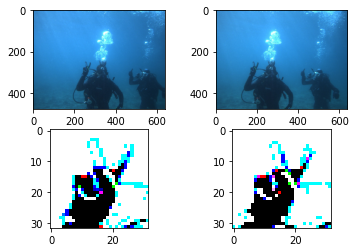

Classified as: two
Probability of classification: 0.9999951124191284


In [107]:
#showing the network result
fig, _axs = plt.subplots(nrows=2, ncols=2)
axs = _axs.flatten()

axs[0].imshow(orig_imL.numpy()[0].transpose(1,2,0))
axs[1].imshow(orig_imR.numpy()[0].transpose(1,2,0))

axs[2].imshow(imageL_batch[0].cpu().numpy().transpose(1,2,0))
axs[3].imshow(imageR_batch[0].cpu().numpy().transpose(1,2,0))

plt.show()

print('Classified as: {}'.format(classes[np.argmax(np_output_im)]))
print('Probability of classification: {}'.format(np.max(np_output_im)))